In [3]:
import os, warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
warnings.filterwarnings('ignore') 

In [4]:
from random import shuffle
import sys, os
from datetime import datetime, timedelta
import numpy as np , pandas as pd
import time
import joblib
import random
import multiprocessing


from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args
from skopt import Optimizer # for the optimization
from joblib import Parallel, delayed # for the parallelization


import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from vae_dense_model import VariationalAutoencoderDense as VAE_Dense
from vae_conv_model import VariationalAutoencoderConv as VAE_Conv
from vae_conv_I_model import VariationalAutoencoderConvInterpretable as VAE_ConvI
from config import config as cfg
import utils

# Define paths

In [5]:
input_dir = "../../data/processed_orig_data/"
output_dir = "../../data/generated_data/"
model_dir = './model/'
log_dir = './log/'
hpo_dir = './hpo_results/'

# Utility Functions

In [8]:
# Set seed for reproducibility
def set_seeds(seed_value):   
    os.environ['PYTHONHASHSEED']=str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

In [9]:
def get_train_valid_split(data, valid_perc):
    N = data.shape[0]
    N_train = int(N * (1 - valid_perc))
    N_valid = N - N_train

    # shuffle data, just in case
    np.random.shuffle(data)

    # train, valid split 
    train_data = data[:N_train]
    valid_data = data[N_train:]
    return train_data, valid_data

In [10]:
def scale_train_valid_data(train_data, valid_data, scaling_method):         
    if scaling_method == 'minmax':    
        scaler = utils.MinMaxScaler( )  
    elif scaling_method == 'standard': 
        raise NotImplementedError(f'Scaling method {scaling_method} not implemented')
    elif scaling_method == 'yeojohnson':
        raise NotImplementedError(f'Scaling method {scaling_method} not implemented')
    else:         
        raise NotImplementedError(f'Scaling method {scaling_method} not implemented')       
          
    scaled_train_data = scaler.fit_transform(train_data)
    scaled_valid_data = scaler.transform(valid_data)
    return scaled_train_data, scaled_valid_data, scaler

## Main VAE Train and Evaluate Function

In [11]:
def train_model(train_data, latent_dim, n_layer1_in_20s, n_layer2_in_25s, n_layer3_in_50s, epochs = 100):
    
    _, T, D = train_data.shape

    # ----------------------------------------------------------------------------------------------
    # Instantiate the VAE
    vae = VAE_ConvI( seq_len=T,  
                    feat_dim = D, 
                    latent_dim = int(latent_dim), 
                    hidden_layer_sizes=[ 
                        int(n_layer1_in_20s*20), 
                        int(n_layer2_in_25s*25),
                        int(n_layer3_in_50s*50)], 
                # trend_poly=1, 
                # num_gen_seas=1,
                # custom_seas = [ (7, 1)] ,     # list of tuples of (num_of_seasons, len_per_season)
                use_residual_conn = True
        )

    vae.compile(optimizer=Adam())
    # vae.summary() ; sys.exit()

    # ----------------------------------------------------------------------------------------------
    # Train the VAE
    early_stop_loss = 'loss'
    early_stop_callback = EarlyStopping(monitor=early_stop_loss, min_delta = 1e-1, patience=50) 
    reduceLR = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10)

    history = vae.fit(
        train_data, 
        batch_size = 32,
        epochs=epochs,
        shuffle = True,
        callbacks=[early_stop_callback, reduceLR],
        verbose = 0
    )
    
    # ----------------------------------------------------------------------------------------------
    return vae, history

In [12]:
def evaluate_model(model, valid_data): 
    return model.evaluate(valid_data, verbose = 0, return_dict=True)

# HPO Using Scikit Optimize

## Hyperparameter Space

In [23]:
# determine the hyperparameter space
param_grid = [
    Integer(2, 10, name="latent_dim"),
    Integer(1, 5, name="n_layer1_in_20s"),
    Integer(1, 8, name="n_layer2_in_25s"),
    Integer(1, 8, name="n_layer3_in_50s"),
    Categorical(['minmax'], name="scaling_method"),
]

dim_names = [
    'latent_dim',
    'n_layer1_in_20s',
    'n_layer2_in_25s',
    'n_layer3_in_50s',
    'scaling_method',
]

default_parameters = [
    8,              # latent_dim
    2,             # n_layer1_in_20s 
    4,            # n_layer2_in_25s
    4,            # n_layer3_in_50s
    'minmax'        # scaling_method
]

default_parameters

[8, 2, 4, 4, 'minmax']

## Objective for HPO

In [14]:
@use_named_args(param_grid)
def objective(
            latent_dim,
            n_layer1_in_20s,
            n_layer2_in_25s,
            n_layer3_in_50s,
            scaling_method,
        ):

    global trial_num
    global best_loss
    
    start = time.time()

    # Print the hyper-parameters.   
    print('-------------------------------------------')
    print(f'trial_num: {trial_num}')
    
    print(f'latent_dim: {latent_dim}')
    print(f'n_layer1_in_20s: {n_layer1_in_20s}')
    print(f'n_layer2_in_25s: {n_layer2_in_25s}')
    print(f'n_layer3_in_50s: {n_layer3_in_50s}')
    print(f'scaling_method: {scaling_method}')   
    print()   

    trial_num += 1    
    

    losses = []
    for train_index, valid_index in kf.split(data):  
        
        # grab train/test data using kf indexes
        train_data, valid_data = data[train_index], data[valid_index]
        
        # scale data 
        scaled_train_data, scaled_valid_data, scaler = scale_train_valid_data(train_data, valid_data, scaling_method)
        
        # train model 
        model, history = train_model(scaled_train_data, 
                latent_dim, n_layer1_in_20s, n_layer2_in_25s, n_layer3_in_50s,
                epochs = 100)

        # evaluate on valid data
        score = evaluate_model(model, scaled_valid_data)
        
        # Get the loss after the last training-epoch.        
        losses.append(score['loss'])
        
        
        del model, history
    
    loss = np.mean(losses)
    if loss < best_loss:
        best_loss = loss

    # Print the loss.
    print(f"trial vae loss: {loss}")
    print(f"best vae loss: {best_loss}")
    
    end = time.time()
    print(f"Trial run time: {np.round((end - start)/60.0, 2)} minutes") 
    print('-------------------------------------------')   
    return loss

# Main Time VAE HPO Loop, by dataset

In [26]:
# how many folds in cross validation
num_folds = 5

# num of trials for Bayesian search: initial and total (including initial)
n_initial_points = 5
n_calls = 60


# our model name
model = 'vae_conv_I'

# dataset_names = ['sine', 'stocks', 'air', 'energy']
percs = [2, 5, 10, 20, 100]


# to custom run specific data
dataset_names = ['sine']
percs = [ 100 ]


# set random gen seed for reproducibiity
set_seeds(42)

main_start_time = time.time()    

for data_name in dataset_names:    
    for p in percs:  
        
        # --------------------------------------------------------------------
        ### file name to load
        fname = f'{input_dir + data_name}_subsampled_train_perc_{p}.npz'
        
        ### read data        
        loaded = np.load(fname)
        data = loaded['data']  
        # print(fname, data.shape) 
        
        # --------------------------------------------------------------------
        
        # k-folds 
        kf = KFold(n_splits=num_folds)
        
        # --------------------------------------------------------------------
        best_loss = 1e10
        trial_num = 1
        
        # bayesian search
        gp_ = gp_minimize(
            objective, # the objective function to minimize
            param_grid, # the hyperparameter space
            x0=default_parameters, # the initial parameters to test
            acq_func='EI', # the acquisition function
            n_initial_points=n_initial_points,
            n_calls=n_calls, # the number of subsequent evaluations of f(x)
            random_state=0, 
            n_jobs=7
        )
        
        # pickle the gp_min object        
        gp_min_fname = f'{hpo_dir}hpo_gp_obj_{model}_{data_name}_perc_{p}.pkl'   # 
        joblib.dump(gp_, gp_min_fname)
        
        # also save the results in a csv
        hpo_results_fname = f'{hpo_dir}hpo_results_{model}_{data_name}_perc_{p}.csv'   # 
        df = pd.concat([
            pd.DataFrame(gp_.x_iters),
            pd.Series(gp_.func_vals),
        ], axis=1)

        df.columns = dim_names + ['loss']

        df.sort_values(by='loss', ascending=True, inplace=True)
        df.to_csv(hpo_results_fname, index=False)
        
        del gp_

end = time.time()
elapsed_time = np.round((end - main_start_time)/60.0, 2)
print(f"All done in {elapsed_time} minutes!")  

-------------------------------------------
trial_num: 1
latent_dim: 8
n_layer1_in_20s: 2
n_layer2_in_25s: 4
n_layer3_in_50s: 4
scaling_method: minmax

trial vae loss: 568.5732421875
best vae loss: 568.5732421875
Trial run time: 0.58 minutes
-------------------------------------------
-------------------------------------------
trial_num: 2
latent_dim: 7
n_layer1_in_20s: 4
n_layer2_in_25s: 7
n_layer3_in_50s: 7
scaling_method: minmax

trial vae loss: 552.1331420898438
best vae loss: 552.1331420898438
Trial run time: 0.49 minutes
-------------------------------------------
-------------------------------------------
trial_num: 3
latent_dim: 5
n_layer1_in_20s: 2
n_layer2_in_25s: 1
n_layer3_in_50s: 3
scaling_method: minmax

trial vae loss: 561.39052734375
best vae loss: 552.1331420898438
Trial run time: 0.69 minutes
-------------------------------------------
-------------------------------------------
trial_num: 4
latent_dim: 8
n_layer1_in_20s: 3
n_layer2_in_25s: 4
n_layer3_in_50s: 7
scal

# Inspect Results

In [27]:
# function value at the minimum.
# note that it is the negative of the accuracy

dataset_name = 'sine'
perc = 2

f_name = f'{hpo_dir}hpo_results_{model}_{data_name}_perc_{p}.pkl'


In [28]:
gp_ = joblib.load(f_name)
"Best score=%.4f" % gp_.fun

'Best score=506.5653'

# Evaluate convergence of the search

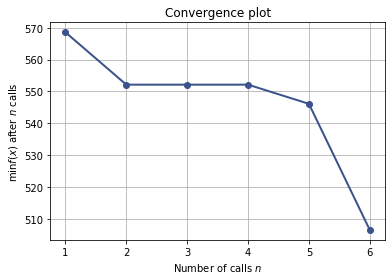

In [29]:
plot_convergence(gp_)

# Results in a Dataframe

In [30]:
# all together in one dataframe, so we can investigate further

tmp = pd.concat([
    pd.DataFrame(gp_.x_iters),
    pd.Series(gp_.func_vals),
], axis=1)

tmp.columns = dim_names + ['loss']

tmp.sort_values(by='loss', ascending=True, inplace=True)

tmp.head()

,latent_dim,n_layer1_in_20s,n_layer2_in_25s,n_layer3_in_50s,scaling_method,loss
5,6,4,5,6,minmax,506.565326
4,7,2,8,2,minmax,546.120251
1,7,4,7,7,minmax,552.133142
3,8,3,4,7,minmax,553.479254
2,5,2,1,3,minmax,561.390527
